In [1]:
import gym
import random, math
import numpy as np
import arcade
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image

        
from LightEnvCopy import LightEnv

import gym.spaces
from gym.spaces import Discrete, Box

from ray.rllib.env.env_context import EnvContext
from ray.rllib.models import ModelCatalog

from collections import namedtuple

# Do the math to figure out our screen dimensions
SCREEN_WIDTH = 800
SCREEN_HEIGHT = 600
SCREEN_TITLE = "Game 1: Let There Be Light!"

# COnvenient data structure to hold information about actions
Action = namedtuple('Action', 'name index delta_i delta_j')

up = Action('up', 0, -1, 0)    
down = Action('down', 1, 1, 0)    
left = Action('left', 2, 0, -1)    
right = Action('right', 3, 0, 1)    

index_to_actions = {}
for action in [up, down, left, right]:
    index_to_actions[action.index] = action
# print(index_to_actions[0].name)
str_to_actions = {}
for action in [up, down, left, right]:
    str_to_actions[action.name] = action
#TF End - Adding in actions for action conversion


class LightEnvWrapper(gym.Env, LightEnv):
    """Class that wraps the Lights Environment to make it 
    compatible with RLLib."""

    metadata = {"render.modes": ["rgb_array", "state_pixels"]}
    
    def __init__(self, config: EnvContext):
        super().__init__(SCREEN_WIDTH, SCREEN_HEIGHT, SCREEN_TITLE)
        self.counting = 0    
        self.torch_collected = False
        self.torch_collected_count = []
        self.mygame = LightEnv
        
        #The action space is a choice of 4 actions: U/D/L/R.
        self.action_space = Discrete(4)
        
        #The observation space is a fixed image of the current game screen
        self.observation_space = Box(low=0, high=255, shape=(84,84, 4), dtype=np.uint8)
        
        self.counting = 0

    def reset(self):
        print("resetting in wrapper")
        
        if self.torch_collected == 1:
            print("Torch was collected this episode!")
        else:
            print("Torch was not collected this episode...")
        self.torch_collected_count.append(self.torch_collected)
        print(self.torch_collected_count)

        self.render(self)
        #Resets the state of the environment for a new episode and an initial observation.
        obs_mygame = self.mygame.reset(self)
        
        #Open up the resetted image to verify working correctly.
        obs_mygame.show()
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs = self.convert_observations(obs_mygame)
        
        return obs

    def step(self, action):
        self.counting += 1
        
        #Making sure an action is chosen, either: 0, 1, 2, 3.
        assert action in [0, 1, 2, 3] #0-up,1-down,2-left,3-right.
        
        #Convert the numeric action to a keyword: up, down, left, right.
        actions_myenv = index_to_actions[action].name #returns a word, one of: up/down/left/right
#         print(f"action taken: {actions_myenv}")
        
        #Update the window with on_update()
        self.render(self)
        
        #Compute observation extracted from the window (800x600), with reward and done flag.
        obs, reward, done, torch_collected = self.mygame.step(self,actions_myenv)
        if torch_collected == True:
            self.torch_collected = 1
        else:
            self.torch_collected = 0
                    
#         if self.counting % 33 == 0: #33 steps roughly equates to 1 second in game time
#             print(f"total score is {self.score} at time: {self.mygame.time_taken_reported(self)}")
        
        #Convert observation to 84x84 resolution and np array for rllib.
        obs_mygame = self.convert_observations(obs)
        
        #If the reward has been obtained, reset the environment and start again
        if done == True:
            print(f"done is {done}, resetting environment in wrapper.")
            self.reset()
        
        return obs_mygame, reward, done, {}

    def seed(self, seed=None):
        random.seed(seed)

    def convert_observations(self, obs_mygame): #resizing and converting to array for rllib processing
        # We normalize and concatenate observations
        obs = obs_mygame
        obs_resized = obs.resize((84,84))
        obsarray = np.array(obs_resized)
        return obsarray
    
    def render(self, mode='state_pixels'):
        self.mygame.on_update(self, 1/60)
        self.mygame.on_draw(self)
        test = self.mygame.time_taken_reported(self)
        

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if (distutils.version.LooseVersion(tf.__version__) <


### Now run the rllib script to train the agent

### PPO Game 2

In [2]:
import gym
import ray.rllib.agents.ppo.ppo as ppo
from ray.rllib.algorithms.ppo import PPOConfig
from ray import air
from ray import tune
config = PPOConfig()

#sgd minibatch changed from 128 to 256 for game2.
config = PPOConfig().training(gamma=0.9, lr=0.01, kl_coeff=0.2, entropy_coeff=1,
#                               entropy_coeff_schedule=[[0,1],[1000,0]],
                             sgd_minibatch_size=128, num_sgd_iter=60)\
            .resources(num_gpus=0)\
            .rollouts(num_envs_per_worker=1, num_rollout_workers=1, recreate_failed_workers=True)
config.normalize_actions=False
config.env=LightEnvWrapper
config.clip_actions=False
print(config.to_dict())
# Build a Algorithm object from the config
trainer = ppo.PPOTrainer(config=config)

avg_rewards = []
num_iterations = []
for episode in range(1000):
    print("Starting episode ", episode)
    # Perform one iteration of training the policy with PPO
    result = trainer.train()
    #print(pretty_print(result))
    print("episode reward mean: ", result['episode_reward_mean'])
    avg_rewards.append(result['episode_reward_mean'])
    num_iterations.append(episode)
    if episode % 10 == 0:
        checkpoint = trainer.save()
        print("checkpoint saved at", checkpoint)
    print("End of episode ", episode)



    

{'extra_python_environs_for_driver': {}, 'extra_python_environs_for_worker': {}, 'num_gpus': 0, 'num_cpus_per_worker': 1, 'num_gpus_per_worker': 0, '_fake_gpus': False, 'custom_resources_per_worker': {}, 'placement_strategy': 'PACK', 'eager_tracing': False, 'eager_max_retraces': 20, 'tf_session_args': {'intra_op_parallelism_threads': 2, 'inter_op_parallelism_threads': 2, 'gpu_options': {'allow_growth': True}, 'log_device_placement': False, 'device_count': {'CPU': 1}, 'allow_soft_placement': True}, 'local_tf_session_args': {'intra_op_parallelism_threads': 8, 'inter_op_parallelism_threads': 8}, 'env': <class '__main__.LightEnvWrapper'>, 'env_config': {}, 'observation_space': None, 'action_space': None, 'env_task_fn': None, 'render_env': False, 'clip_rewards': None, 'normalize_actions': False, 'clip_actions': False, 'disable_env_checking': False, 'num_workers': 1, 'num_envs_per_worker': 1, 'sample_collector': <class 'ray.rllib.evaluation.collectors.simple_list_collector.SimpleListCollecto

C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\ray_option_utils.py:266: DeprecationWarning: Setting 'object_store_memory' for actors is deprecated since it doesn't actually reserve the required object store memory. Use object spilling that's enabled by default (https://docs.ray.io/en/releases-2.0.0/ray-core/objects/object-spilling.html) instead to bypass the object store memory size limitation.
  warnings.warn(
2022-09-21 01:54:18,837	INFO worker.py:1518 -- Started a local Ray instance.
(pid=21924) Windows fatal exception: code 0xc0000139
(pid=21924) 
(pid=21924) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=21924)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=21924) 2022-09-21 01:54:33,263	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you hav

(RolloutWorker pid=21924) resetting in wrapper
(RolloutWorker pid=21924) Torch was not collected this episode...
(RolloutWorker pid=21924) [False]
(RolloutWorker pid=21924) resetting


2022-09-21 01:54:38,694	INFO trainable.py:160 -- Trainable.setup took 22.455 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-09-21 01:54:38,699	WARNING util.py:65 -- Install gputil for GPU system monitoring.


Starting episode  0
(RolloutWorker pid=21924) resetting in wrapper
(RolloutWorker pid=21924) Torch was not collected this episode...
(RolloutWorker pid=21924) [False, 0]
(RolloutWorker pid=21924) resetting
episode reward mean:  nan
checkpoint saved at C:\Users\Tim/ray_results\PPO_LightEnvWrapper_2022-09-21_01-54-169v3hnijo\checkpoint_000001
End of episode  0
Starting episode  1
episode reward mean:  nan
End of episode  1
Starting episode  2
episode reward mean:  nan
End of episode  2
Starting episode  3
episode reward mean:  nan
End of episode  3
Starting episode  4
episode reward mean:  nan
End of episode  4
Starting episode  5
episode reward mean:  nan
End of episode  5
Starting episode  6
episode reward mean:  nan
End of episode  6
Starting episode  7
episode reward mean:  nan
End of episode  7
Starting episode  8
episode reward mean:  nan
End of episode  8
Starting episode  9
episode reward mean:  nan
End of episode  9
Starting episode  10
episode reward mean:  nan
checkpoint saved

episode reward mean:  -1556.0
End of episode  75
Starting episode  76
episode reward mean:  -1556.0
End of episode  76
Starting episode  77
episode reward mean:  -1556.0
End of episode  77
Starting episode  78
episode reward mean:  -1556.0
End of episode  78
Starting episode  79
episode reward mean:  -1556.0
End of episode  79
Starting episode  80
episode reward mean:  -1556.0
checkpoint saved at C:\Users\Tim/ray_results\PPO_LightEnvWrapper_2022-09-21_01-54-169v3hnijo\checkpoint_000081
End of episode  80
Starting episode  81
(RolloutWorker pid=21924) Game completed with a score of: -424 at time: 499
(RolloutWorker pid=21924) done is True, resetting environment in wrapper.
(RolloutWorker pid=21924) resetting in wrapper
(RolloutWorker pid=21924) Torch was collected this episode!
(RolloutWorker pid=21924) [False, 0, 1, False, 1, False, 1, False, 1]
(RolloutWorker pid=21924) resetting
(RolloutWorker pid=21924) resetting in wrapper
(RolloutWorker pid=21924) Torch was not collected this epis

2022-09-21 15:57:22,114	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

(pid=148) Windows fatal exception: code 0xc0000139
(pid=148) 
(pid=148) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=148)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=148) 2022-09-21 15:57:42,826	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=148) resetting in wrapper
(RolloutWorker pid=148) Torch was not collected this episode...
(RolloutWorker pid=148) [False]
(RolloutWorker pid=148) resetting
(RolloutWorker pid=148) resetting in wrapper
(RolloutWorker pid=148) Torch was not collected this episode...
(RolloutWorker pid=148) [False, 0]
(RolloutWorker pid=148) resetting


2022-09-21 15:58:12,143	ERROR algorithm.py:2173 -- Error in training or evaluation attempt! Trying to recover.
Traceback (most recent call last):
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\algorithm.py", line 2373, in _run_one_training_iteration
    results = self.training_step()
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\algorithms\ppo\ppo.py", line 407, in training_step
    train_batch = synchronous_parallel_sample(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\rllib\execution\rollout_ops.py", line 100, in synchronous_parallel_sample
    sample_batches = ray.get(
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\client_mode_hook.py", line 105, in wrapper
    return func(*args, **kwargs)
  File "C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\ray\_private\worker.py", line 2275, in get
    raise value.as_instanceof_cause()
ray.exceptions.RayTaskError(RayOutOfMemoryError): ray::

(pid=20052) Windows fatal exception: code 0xc0000139
(pid=20052) 
(pid=20052) C:\Users\Tim\Anaconda3\envs\rllib\lib\site-packages\tensorflow_probability\python\__init__.py:57: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
(pid=20052)   if (distutils.version.LooseVersion(tf.__version__) <
(RolloutWorker pid=20052) 2022-09-21 15:58:25,249	WARNING env.py:142 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.


(RolloutWorker pid=20052) resetting in wrapper
(RolloutWorker pid=20052) Torch was not collected this episode...
(RolloutWorker pid=20052) [False]
(RolloutWorker pid=20052) resetting
(RolloutWorker pid=20052) resetting in wrapper
(RolloutWorker pid=20052) Torch was not collected this episode...
(RolloutWorker pid=20052) [False, 0]
(RolloutWorker pid=20052) resetting
episode reward mean:  -1015.8
End of episode  87
Starting episode  88
(RolloutWorker pid=20052) Game completed with a score of: -24 at time: 113
(RolloutWorker pid=20052) done is True, resetting environment in wrapper.
(RolloutWorker pid=20052) resetting in wrapper
(RolloutWorker pid=20052) Torch was collected this episode!
(RolloutWorker pid=20052) [False, 0, 1]
(RolloutWorker pid=20052) resetting
(RolloutWorker pid=20052) resetting in wrapper
(RolloutWorker pid=20052) Torch was not collected this episode...
(RolloutWorker pid=20052) [False, 0, 1, False]
(RolloutWorker pid=20052) resetting
episode reward mean:  -850.5
End 

KeyboardInterrupt: 

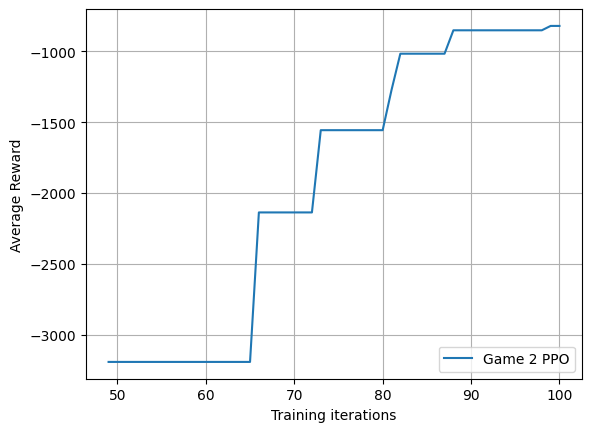

In [3]:
import matplotlib.pyplot as plt
plt.plot(num_iterations, avg_rewards, label="Game 2 PPO")       
plt.xlabel("Training iterations")
plt.ylabel("Average Reward")
plt.legend(loc=4)
plt.grid(True)
plt.show()